### Figure 9: PTdetector Detection Performance after Excluding Frameworks

The related experiment data is arranged as follow.

`detection_result.csv` @ The detection result after applying PTdetector on 80 top-traffic web pages.
- `domain`: The domain name
- `rank`: The domain rank
- `url`: The home page url under the domain
- `ground truth`: The ground truth library loaded on the web page
- `PTdetector`: The libraries identified by PTdetector

We define a class named `ConfMatrix` to provide basic functions to confusion matrix related calculation.

In [1]:
class ConfMatrix():
    def __init__(self, black_list=[]):
        self.BLACK_LIST = black_list
        self.TOTAL_LIB_NUM = 83

    def confusionMatrix(self, truelist, list):
        tp = 0
        for item in list:
            if item['name'] in [item2['name'] for item2 in truelist]:
                tp += 1
        fn = len(truelist) - tp

        fp = 0
        for item in list:
            if item['name'] not in [item2['name'] for item2 in truelist]:
                fp += 1
                
        tn = self.TOTAL_LIB_NUM - len(self.BLACK_LIST) - tp - fn - fp

        return tp, fn, fp, tn

    def calValue(self, TP, FN, FP, TN):
        # Accuracy
        Accu = round((TP + TN) * 100 / (TP + FP + FN + TN), 2)
        # Precision
        Pre = round(TP * 100 / (TP + FP), 2)
        # Recall
        Recall = round(TP * 100 / (TP + FN), 2)

        return Accu, Pre, Recall

    def filter(self, list, threshold=50):
        # Receive library object list
        new_list = []
        for lib_obj in list:
            if lib_obj["score"] == None or lib_obj["score"] >= threshold:
                new_list.append(lib_obj)          
        return new_list
    
    def convertToObject(self, str_list):
        # <libname> @ <version> : <score> ! <depth>
        obj_list = []
        for str in str_list:
            obj = {}
            _depth_pos = str.find('!')
            if _depth_pos != -1:
                obj['depth'] = int(str[_depth_pos + 1:])
                str = str[:_depth_pos]
            else:
                obj['depth'] = None

            _colon_pos = str.find(':')
            if _colon_pos != -1:
                obj['score'] = float(str[_colon_pos + 1:])
                str = str[:_colon_pos]
            else:
                obj['score'] = None

            _at_pos = str.find('@')
            if _at_pos != -1:
                obj['version'] = str[_at_pos + 1:]
                str = str[:_at_pos]
            else:
                obj['version'] = None

            obj['name'] = str

            if str not in self.BLACK_LIST:
                obj_list.append(obj)

        return obj_list

Following code collects accuracy, precision, and recall of PTdetector under different score threshold setting, and draw on a line plot.

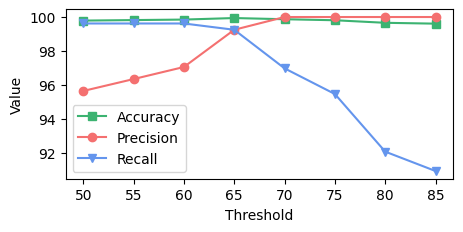

In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt

CM = ConfMatrix(black_list=["Bootstrap","Ext JS","Preact","React","Vue","Angular"])

df= pd.read_csv("./detection_result.csv",delimiter=';')
gt_column = df['ground truth'].tolist()
tool_column = df['PTdetector'].tolist()

def analyze(threshold):
    TP, FN, FP, TN = 0, 0, 0, 0
    for i in range(len(tool_column)):
        # Decode library result string
        list0 = CM.convertToObject(json.loads(gt_column[i]))
        list1 = CM.convertToObject(json.loads(tool_column[i]))

        # Filter based on score threshold
        if threshold != None:
            list1 = CM.filter(list1, threshold)
            
        tp, fn, fp, tn = CM.confusionMatrix(list0, list1)
        TP += tp
        FN += fn
        FP += fp
        TN += tn

    return CM.calValue(TP, FN, FP, TN)

if __name__ == "__main__":
    thresholds = []
    accus = []
    precs = []
    recalls = []
    for v in range(50, 90, 5):
        a, p, r = analyze(v)
        thresholds.append(v)
        accus.append(a)
        precs.append(p)
        recalls.append(r)
    
    # plot reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
    plt.plot(thresholds, accus, 's-', color='mediumseagreen', label='Accuracy')
    plt.plot(thresholds, precs, 'o-', color='#f47070', label='Precision')
    plt.plot(thresholds, recalls, 'v-', color='cornflowerblue', label='Recall')
    plt.xlabel("Threshold")
    plt.ylabel("Value")
    plt.legend(loc="best")
    plt.rcParams['figure.figsize'] = [5, 2.2]
    plt.show()